In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertModel, BertTokenizer, BertConfig
import numpy as np
import os
import struct
import matplotlib.pyplot as plt
import pandas as pd

class TimeSeriesDataset(Dataset):
    def __init__(self, filepath, sequence_length, max_samples=None):
        print('def init dataset')
        self.filepath = filepath
        self.sequence_length = sequence_length
        self.max_samples = max_samples
        self.total_samples = self.count_total_samples() - sequence_length
        if max_samples is not None:
            self.total_samples = min(self.total_samples, max_samples)

    def count_total_samples(self):
        print('def count dataset')
        with open(self.filepath, 'rb') as f:
            f.seek(0, os.SEEK_END)
            return f.tell() // 8  # Two floats per sample

    def __len__(self):
        print('def len dataset')
        return self.total_samples
    
    def __getitem__(self, idx):
        if idx >= self.total_samples:
            raise IndexError("Index out of bounds")
        with open(self.filepath, 'rb') as binary_file:
            binary_file.seek(8 * (self.sequence_length + idx), os.SEEK_SET)
            seq_data = binary_file.read(8 * self.sequence_length)
            sample = np.frombuffer(seq_data, dtype=np.float32).reshape(self.sequence_length, 2)
        if idx % (self.total_samples // 10) == 0:  # print 10 times throughout the dataset
            print(f'Item {idx} shape: {sample.shape} - Sample data: {sample[0]}')  # Print the shape and first sample
        return torch.tensor(sample, dtype=torch.float32)



class TimeSeriesBERT(nn.Module):
    def __init__(self, bert_model_name='bert-base-uncased'):
        super(TimeSeriesBERT, self).__init__()
        self.bert_config = BertConfig.from_pretrained(bert_model_name)
        self.bert_model = BertModel(self.bert_config)
        self.sequence_length = 10  # This should match with what are using in dataset preparation
        # need to embed each of the sequence's features (2 features per timestamp) to the BERT dimension.
        # Since BERT expects a sequence, we flatten the 2 features into the sequence itself, so the input
        # to the BERT model becomes (batch_size, sequence_length * 2), hence embedding should match this.
        self.time_series_embedding = nn.Linear(2, self.bert_config.hidden_size)
        self.linear = nn.Linear(self.bert_config.hidden_size, 2)  # Mapping back to the original space

    def forward(self, x):
        # Process each time step's feature vector through the same feed-forward network
        # to produce embeddings for the entire sequence
        # x has shape: [batch_size, sequence_length, feature_size (2)]
        #print('x.shape before reshape:', x.shape)
        batch_size, seq_len, feat_size = x.shape
        # Flatten out the time step dimension so that we have a series of vectors for each time step
        x = x.view(batch_size * seq_len, feat_size)
        #print('x after reshape:', x)
        #print('x.shape after reshape:', x.shape)
        # Embed the time step feature vectors to BERT input dimension
        x_embeds = self.time_series_embedding(x)  # shape now [batch_size*sequence_length, hidden_size]
        #print('x_embeds after embedding:', x_embeds)
        #print('x_embeds.shape after embedding:', x_embeds.shape)
        # Reshape to get the sequence for BERT
        x_embeds = x_embeds.view(batch_size, seq_len, -1)  # shape [batch_size, sequence_length, hidden_size]
        #print('x_embeds.shape after embed.reshape:', x_embeds.shape)
        # Get BERT's output for the sequence
        bert_outputs = self.bert_model(inputs_embeds=x_embeds)
        #print('bert_outputs:', bert_outputs)
        sequence_output = bert_outputs.last_hidden_state
        #print('sequence_output:', sequence_output)
        # Reshape output to match the input sequence layout for comparison
        # Flatten the sequence_output to match with the flattened sequence input to calculate loss correctly
        sequence_output = sequence_output.view(batch_size * seq_len, -1)  # shape [batch_size*sequence_length, hidden_size]
        
        # Map the sequence_output predictions back to the original feature space (2 features per time step)
        output = self.linear(sequence_output)  # shape now [batch_size*sequence_length, feature_size (2)]
        #print('output:', output)
        # Reshape to the original batch's shape
        output = output.view(batch_size, seq_len, -1)  # shape [batch_size, sequence_length, feature_size (2)]
        #print('output reshaped:', output)
        return output

# Use the dataset class
batch_size = 256
sequence_length = 100
max_samples = 4000000  # can limit the maximum number of samples to read

train_dataset = TimeSeriesDataset(
    filepath='/home/mreza/5G accelerator/models/5G_DL_IQ_no_jamming_0924.dat',
    sequence_length=sequence_length,
    max_samples=max_samples
)
print('tarin_dataset passed!!')
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print('train_dataloader passed!!')

test_dataset = TimeSeriesDataset(
    filepath='/home/mreza/5G accelerator/models/5G_DL_IQ_with_periodic_jamming_0928_02.dat',
    sequence_length=sequence_length,
    max_samples=max_samples
)
print('test_dataset passed!!')
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print('test_dataloaderr passed!!')

# Initialize model and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TimeSeriesBERT().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

# Training loop
avg_train_loss = []
avg_eval_loss = []
train_loss = []
eval_loss = []
num_epochs = 3
print_every_n_batches = 10  # Choose how often to print

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_idx, batch in enumerate(train_dataloader):
        #print('batch:', batch)
        #print('batch.shape:', batch.shape)
        #print('batch_idx:', batch_idx)
        optimizer.zero_grad()
        batch = batch.to(device)  # Move data to the device
        outputs = model(batch)
        loss = nn.MSELoss()(outputs, batch)  # Assuming batch itself is the target
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        train_loss.append(loss.item())

        if batch_idx % print_every_n_batches == 0:
            # Print loss every n batches
            print(f'Epoch: {epoch+1}, Batch: {batch_idx}/{len(train_dataloader)}, Loss: {loss.item()}')

    # Print average loss after each epoch
    average_train_loss = total_loss / len(train_dataloader)
    avg_train_loss.append(average_train_loss)
    print(f'Epoch {epoch+1} completed, Average Loss: {average_train_loss}')

# Anomaly detection
model.eval()
reconstruction_errors = []
print_every_n_batches = 10  # Or set to the frequency you prefer

with torch.no_grad():
    total_eval_loss = 0
    for batch_idx, batch in enumerate(test_dataloader):
        batch = batch.to(device)
        outputs = model(batch)
        error = nn.MSELoss(reduction='none')(outputs, batch).mean(dim=1).cpu().numpy()
        reconstruction_errors.extend(error)
#         loss = error.mean()
#         total_eval_loss += loss.item() * batch.size(0)
        batch_loss = error.mean()  # We compute the mean error for the batch
        #total_eval_loss += batch_loss * batch.size(0)
        total_eval_loss += np.sum(error)
        eval_loss.append(np.sum(error))
        #total_eval_loss += loss.item()
        
        # Optionally print out the error stats for the current batch
        if batch_idx % print_every_n_batches == 0:
            print(f"Batch {batch_idx}/{len(test_dataloader)} - Error Stats: Min: {np.min(error):.4f}, Max: {np.max(error):.4f}, Mean: {np.mean(error):.4f}, StdDev: {np.std(error):.4f}")
            
    average_eval_loss = total_eval_loss / len(test_dataloader.dataset)
    avg_eval_loss.append(average_eval_loss)
    print(f'Epoch {epoch+1} completed, Average Evaluation Loss: {average_eval_loss}')
            
reconstruction_errors = np.array(reconstruction_errors)
print(f"Total Batches Processed: {len(test_dataloader)} - Overall Error Stats: Min: {np.min(reconstruction_errors):.4f}, Max: {np.max(reconstruction_errors):.4f}, Mean: {np.mean(reconstruction_errors):.4f}, StdDev: {np.std(reconstruction_errors):.4f}")

threshold = np.percentile(reconstruction_errors, 95)
print('Threshold:', threshold)

# Detect anomalies using the calculated threshold
anomalies = reconstruction_errors > threshold
print('Anomalies detected:', np.sum(anomalies))

def init dataset
def count dataset
tarin_dataset passed!!
def len dataset
def len dataset
train_dataloader passed!!
def init dataset
def count dataset
test_dataset passed!!
test_dataloaderr passed!!
def len dataset
def len dataset
Item 1800 shape: (10, 2) - Sample data: [-0.00683614  0.00097659]
def len dataset
Epoch: 1, Batch: 0/100, Loss: 0.17780928313732147
def len dataset
Epoch: 1, Batch: 10/100, Loss: 0.03141374886035919
Item 1400 shape: (10, 2) - Sample data: [-0.00439466 -0.00341807]
Item 1200 shape: (10, 2) - Sample data: [-0.00683614 -0.00488296]
def len dataset
Epoch: 1, Batch: 20/100, Loss: 0.10852289944887161
Item 200 shape: (10, 2) - Sample data: [-0.00488296 -0.00244148]
def len dataset
Epoch: 1, Batch: 30/100, Loss: 0.04230927303433418
Item 0 shape: (10, 2) - Sample data: [-0.00292978 -0.00097659]
def len dataset
Epoch: 1, Batch: 40/100, Loss: 0.041965775191783905
Item 400 shape: (10, 2) - Sample data: [-0.00390637 -0.00537126]
def len dataset
Epoch: 1, Batch: 50/100, Lo

In [3]:

# Summarize results in a table
summary_data = {
    'Total Samples': [len(reconstruction_errors)],
    'Anomalies Detected': [np.sum(anomalies)],
    'Normal': [len(reconstruction_errors) - np.sum(anomalies)],
    'Threshold': [threshold],
    'Min Error': [np.min(reconstruction_errors)],
    'Max Error': [np.max(reconstruction_errors)],
    'Mean Error': [np.mean(reconstruction_errors)],
    'Error StdDev': [np.std(reconstruction_errors)]
}
summary_table = pd.DataFrame(summary_data)

print(summary_table)


   Total Samples  Anomalies Detected  Normal  Threshold  Min Error  Max Error  \
0           2000                 200    1800   0.005812   0.000104   0.010785   

   Mean Error  Error StdDev  
0    0.002646      0.001663  


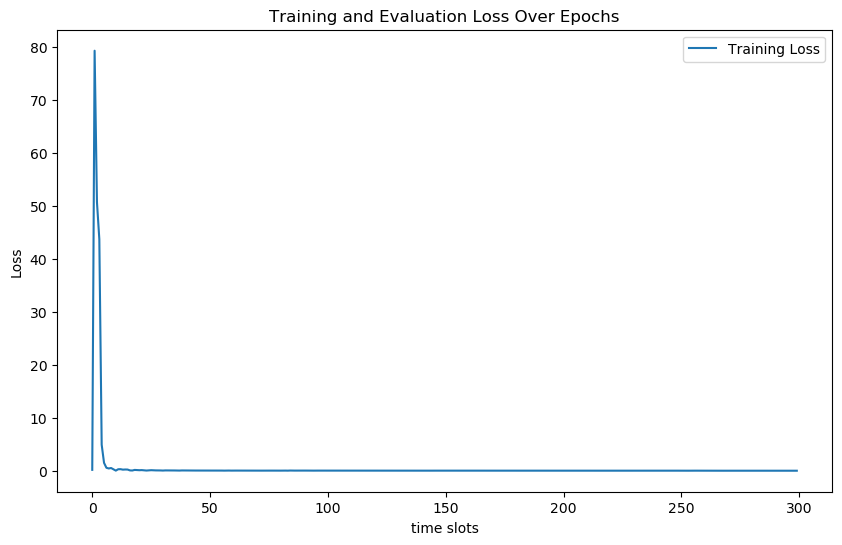

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
#plt.plot(eval_loss, label='Evaluation Loss')
plt.title('Training and Evaluation Loss Over Epochs')
plt.xlabel('time slots')
plt.ylabel('Loss')
plt.legend()
plt.show()

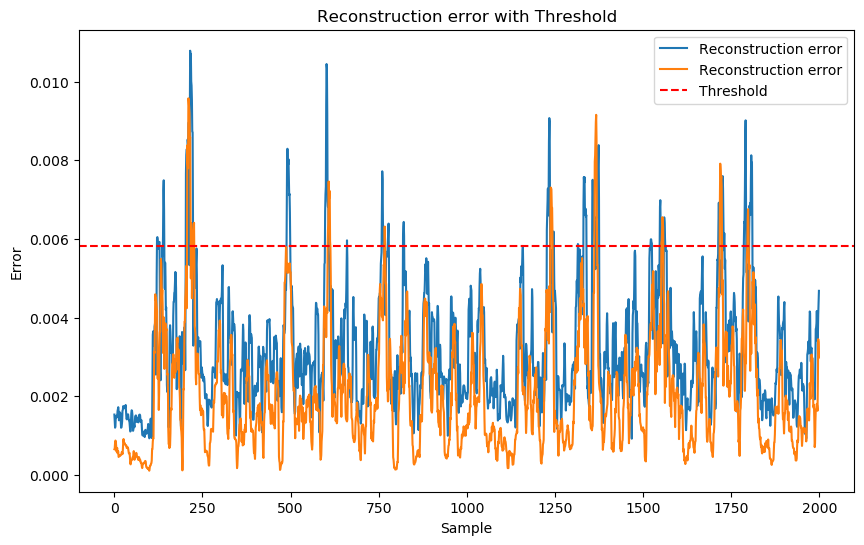

In [7]:
# Reconstruction Error with Threshold
plt.figure(figsize=(10, 6))
plt.plot(reconstruction_errors, label='Reconstruction error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction error with Threshold')
plt.xlabel('Sample')
plt.ylabel('Error')
plt.legend()
plt.show()



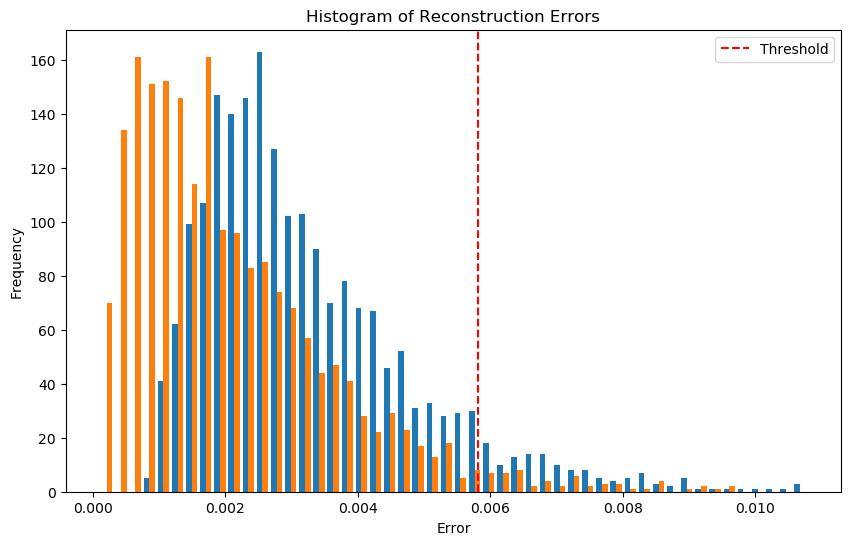

In [8]:
# Histogram of Reconstruction Errors
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_errors, bins=50)
plt.axvline(x=threshold, color='r', linestyle='--', label='Threshold')
plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [9]:
print("Length of range:", len(range(len(reconstruction_errors))))
print("Length of reconstruction errors:", len(reconstruction_errors))
# Since "main data" isn't specified here, let's consider "main data" to be the indices of our samples
# plt.figure(figsize=(10, 6))
# plt.scatter(range(len(reconstruction_errors)), reconstruction_errors, label='Reconstruction error')
# plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
# plt.title('Scatter Plot of Reconstruction Errors vs. Sample Index')
# plt.xlabel('Sample Index')
# plt.ylabel('Reconstruction Error')
# plt.legend()
# plt.show()


Length of range: 2000
Length of reconstruction errors: 2000


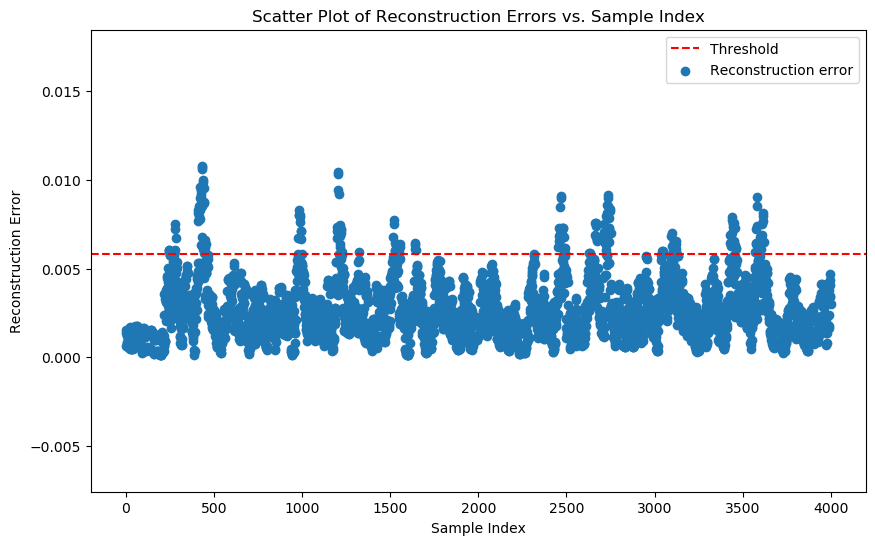

In [11]:
# Ensure reconstruction_errors is a one-dimensional array before plotting
reconstruction_errors_flat = np.ravel(reconstruction_errors)  # Flatten the array

plt.figure(figsize=(10, 6))
plt.scatter(range(len(reconstruction_errors_flat)), reconstruction_errors_flat, label='Reconstruction error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.title('Scatter Plot of Reconstruction Errors vs. Sample Index')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.show()
